# 04: Causal Modeling

This notebook estimates causal effects of sycophancy on user engagement.

## Research Questions
1. Does sycophancy causally affect battle outcomes?
2. Does sycophancy affect user return rates?
3. Are these effects heterogeneous across topics?

## Methodology
- Control for confounders: model quality, topic, response length, politeness
- Propensity score weighting
- Regression with controls

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## 1. Prepare Analysis Dataset

In [2]:
from quant_syco.data.process import build_battle_table, compute_all_metrics
from quant_syco.features.topics import compute_topic_features
from quant_syco.features.lexical import compute_response_length_features
from quant_syco.config import LABELS_DIR

# Load battles with all features
battles = build_battle_table()
battles = compute_topic_features(battles)
battles = compute_response_length_features(battles)

# Load labels
label_files = list(LABELS_DIR.glob('labels_*_merged.parquet'))
labels = pd.read_parquet(label_files[0])

# Merge
df = battles.merge(labels, on='question_id', how='inner')

# Add return metrics if available
try:
    metrics = compute_all_metrics()
    returns = metrics['returns'][['question_id', 'returned_7d', 'returned_30d']]
    df = df.merge(returns, on='question_id', how='left')
except Exception as e:
    print(f"Could not load return metrics: {e}")

print(f"Analysis dataset: {len(df):,} battles")
print(f"Columns: {list(df.columns)}")

Loading cached data from /Users/nijjohnson/Projects/quant-sycophantic/data/raw/lmsys_raw.parquet

Processing 33,000 battles...

Built battle table with 33,000 rows

Columns: ['question_id', 'user_id', 'judge', 'ts_utc', 'model_a', 'model_b', 'winner', 'language', 'user_prompt', 
'assistant_a', 'assistant_b', 'turn', 'anony', 'openai_moderation', 'toxic_chat_tag']

Loading cached data from /Users/nijjohnson/Projects/quant-sycophantic/data/raw/lmsys_raw.parquet

Computed metrics:

- Battles: 33,000 rows

- Returns: 33,000 rows

- Users: 13,383 unique users

Analysis dataset: 33,330 battles
Columns: ['question_id', 'user_id', 'judge', 'ts_utc', 'model_a', 'model_b', 'winner', 'language', 'user_prompt', 'assistant_a', 'assistant_b', 'turn', 'anony', 'openai_moderation', 'toxic_chat_tag', 'topic', 'assistant_a_word_count', 'assistant_a_char_count', 'assistant_b_word_count', 'assistant_b_char_count', 'sycophancy_a', 'politeness_a', 'reasoning_a', 'label_success_a', 'label_error_a', 'sycophancy_b', 'politeness_b', 'reasoning_b', 'label_success_b', 'label_error_b', 'returned_7d', 'returned_30d']


## 2. Define Covariates and Outcomes

In [3]:
# Create binary outcome: A wins
df_model = df[df['winner'].isin(['model_a', 'model_b'])].copy()
df_model['a_wins'] = (df_model['winner'] == 'model_a').astype(int)

# Create sycophancy differential
df_model['syco_diff'] = df_model['sycophancy_a'] - df_model['sycophancy_b']
df_model['polite_diff'] = df_model['politeness_a'] - df_model['politeness_b']
df_model['length_diff'] = df_model['assistant_a_word_count'] - df_model['assistant_b_word_count']

# Drop missing
analysis_cols = ['a_wins', 'syco_diff', 'polite_diff', 'length_diff', 'topic']
df_model = df_model.dropna(subset=analysis_cols)

print(f"Analysis sample: {len(df_model):,} battles (excluding ties and missing)")

Analysis sample: 23,027 battles (excluding ties and missing)


## 3. Winner Model: Sycophancy Effect on Battle Outcomes

In [4]:
from quant_syco.analysis.causal import run_winner_regression

# Simple model
result = run_winner_regression(
    df_model,
    sycophancy_a_col='sycophancy_a',
    sycophancy_b_col='sycophancy_b',
    politeness_a_col='politeness_a',
    politeness_b_col='politeness_b',
    control_cols=['topic', 'length_diff'],
)

print("WINNER REGRESSION RESULTS")
print("=" * 50)
print(f"\nSycophancy Differential Effect:")
print(f"  Coefficient: {result['syco_diff_coef']:.3f}")
print(f"  Odds Ratio: {result['syco_diff_or']:.3f}")
print(f"  P-value: {result['syco_diff_pval']:.4f}")
print(f"\nPoliteness Differential Effect:")
print(f"  Coefficient: {result['polite_diff_coef']:.3f}")
print(f"  P-value: {result['polite_diff_pval']:.4f}")
print(f"\nModel Pseudo-R²: {result['pseudo_r2']:.3f}")
print(f"N: {result['n_obs']:,}")

WINNER REGRESSION RESULTS

Sycophancy Differential Effect:
  Coefficient: 0.036
  Odds Ratio: 1.037
  P-value: 0.0256

Politeness Differential Effect:
  Coefficient: 0.493
  P-value: 0.0000

Model Pseudo-R²: 0.082
N: 23,027


In [5]:
# Full model summary
print(result['summary'])

                           Logit Regression Results                           
Dep. Variable:                 a_wins   No. Observations:                23027
Model:                          Logit   Df Residuals:                    23017
Method:                           MLE   Df Model:                            9
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                 0.08186
Time:                        22:21:48   Log-Likelihood:                -14654.
converged:                       True   LL-Null:                       -15961.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0935      0.087     -1.079      0.280      -0.263       0.076
syco_diff                  0.0362      0.016      2.232      0.026       0.004       0.068
poli

## 4. Visualize Sycophancy Effect

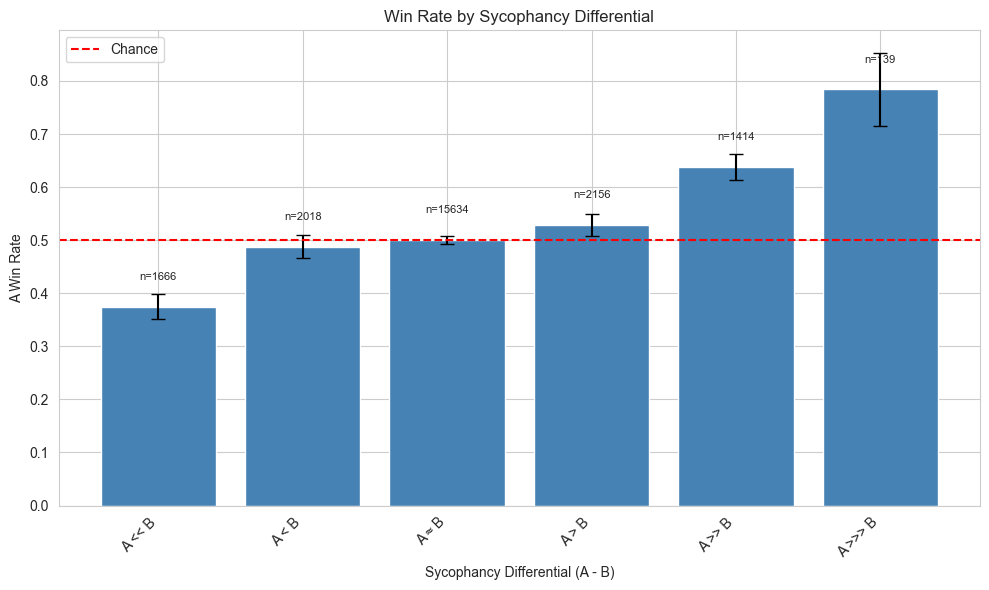

In [6]:
# Win rate by sycophancy differential
df_model['syco_diff_cat'] = pd.cut(
    df_model['syco_diff'], 
    bins=[-4, -2, -1, 0, 1, 2, 4],
    labels=['A << B', 'A < B', 'A ≈ B', 'A > B', 'A >> B', 'A >>> B']
)

win_by_diff = df_model.groupby('syco_diff_cat', observed=True).agg({
    'a_wins': ['mean', 'count', 'std']
}).droplevel(0, axis=1)
win_by_diff.columns = ['win_rate', 'n', 'std']
win_by_diff['se'] = np.sqrt(win_by_diff['win_rate'] * (1 - win_by_diff['win_rate']) / win_by_diff['n'])

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(win_by_diff))
ax.bar(x, win_by_diff['win_rate'], yerr=1.96*win_by_diff['se'], capsize=5, color='steelblue')
ax.axhline(y=0.5, color='red', linestyle='--', label='Chance')

ax.set_xticks(x)
ax.set_xticklabels(win_by_diff.index, rotation=45, ha='right')
ax.set_xlabel('Sycophancy Differential (A - B)')
ax.set_ylabel('A Win Rate')
ax.set_title('Win Rate by Sycophancy Differential')
ax.legend()

# Add sample sizes
for i, (_, row) in enumerate(win_by_diff.iterrows()):
    ax.annotate(f'n={int(row["n"])}', (i, row['win_rate'] + 0.05), ha='center', fontsize=8)

plt.tight_layout()

## 5. Heterogeneous Effects by Topic

In [7]:
from quant_syco.analysis.causal import run_heterogeneous_effects

# Run separate regressions by topic
het_effects = run_heterogeneous_effects(
    df_model,
    outcome_col='a_wins',
    sycophancy_col='syco_diff',
    moderator_col='topic',
    control_cols=['polite_diff', 'length_diff'],
)

het_effects = het_effects.sort_values('sycophancy_coef', ascending=False)
print("Sycophancy Effect by Topic:")
het_effects

Sycophancy Effect by Topic:


,moderator,level,n,sycophancy_coef,sycophancy_pval,sycophancy_ci_lower,sycophancy_ci_upper,p_adjusted,significant_fdr
4,topic,creative_writing,1311,0.624572,1.435315e-17,0.481098,0.768047,1.004721e-16,True
1,topic,opinion,199,0.314000,1.310525e-01,-0.093586,0.721585,2.062853e-01,False
2,topic,other,14370,0.041264,3.760349e-02,0.002365,0.080163,8.774147e-02,False
6,topic,math,912,-0.075922,3.820593e-01,-0.246160,0.094317,3.820593e-01,False
3,topic,coding,2094,-0.127905,1.473466e-01,-0.300920,0.045110,2.062853e-01,False
5,topic,advice,607,-0.152920,2.445559e-01,-0.410487,0.104646,2.853153e-01,False
0,topic,factual_qa,3534,-0.181413,1.674865e-05,-0.264020,-0.098806,5.862029e-05,True


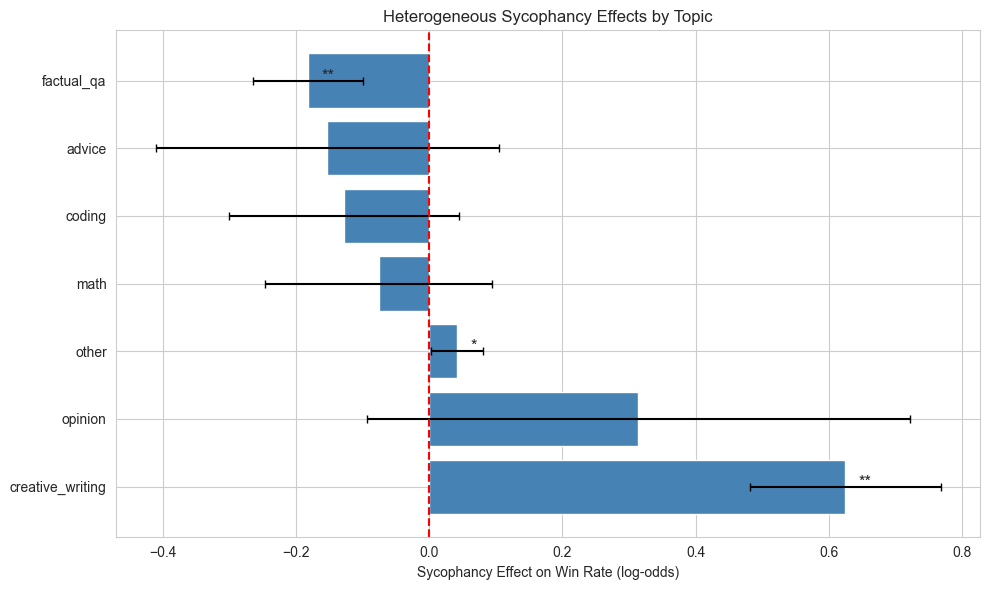

In [8]:
# Visualize heterogeneous effects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot coefficients with CIs
y_pos = np.arange(len(het_effects))

ax.barh(y_pos, het_effects['sycophancy_coef'], 
        xerr=[het_effects['sycophancy_coef'] - het_effects['sycophancy_ci_lower'],
              het_effects['sycophancy_ci_upper'] - het_effects['sycophancy_coef']],
        capsize=3, color='steelblue')

ax.axvline(x=0, color='red', linestyle='--')
ax.set_yticks(y_pos)
ax.set_yticklabels(het_effects['level'])
ax.set_xlabel('Sycophancy Effect on Win Rate (log-odds)')
ax.set_title('Heterogeneous Sycophancy Effects by Topic')

# Add significance stars
for i, row in enumerate(het_effects.itertuples()):
    if row.sycophancy_pval < 0.01:
        ax.annotate('**', (row.sycophancy_coef + 0.02, i), fontsize=12)
    elif row.sycophancy_pval < 0.05:
        ax.annotate('*', (row.sycophancy_coef + 0.02, i), fontsize=12)

plt.tight_layout()

## 6. Propensity Score Analysis

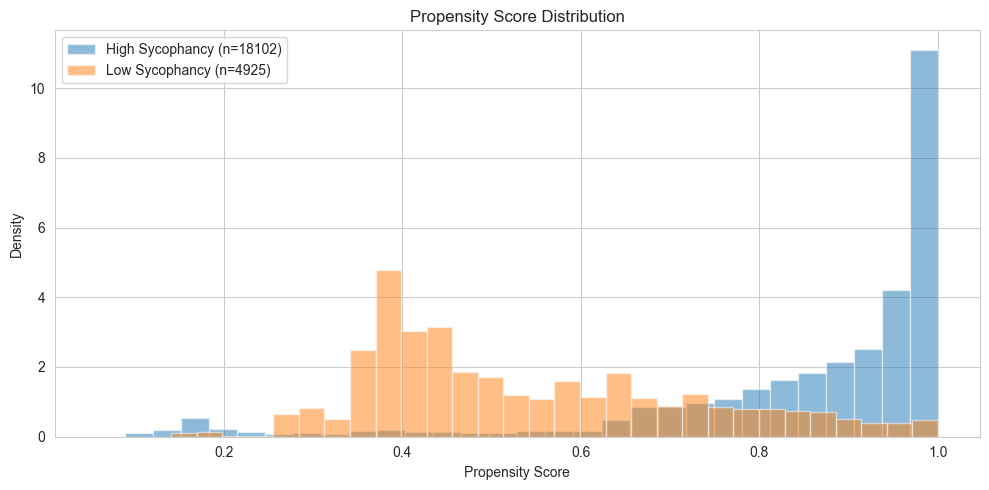

In [9]:
from quant_syco.analysis.causal import compute_propensity_scores, compute_ate

# Define high sycophancy as treatment
df_ps = df_model.copy()
df_ps['high_syco_a'] = (df_ps['sycophancy_a'] >= 2).astype(int)

# Compute propensity scores
df_ps = compute_propensity_scores(
    df_ps,
    treatment_col='sycophancy_a',
    covariate_cols=['topic', 'assistant_a_word_count', 'politeness_a'],
    treatment_threshold=2,
)

# Propensity score distribution
fig, ax = plt.subplots(figsize=(10, 5))

treated = df_ps[df_ps['high_sycophancy'] == 1]['propensity_score']
control = df_ps[df_ps['high_sycophancy'] == 0]['propensity_score']

ax.hist(treated, bins=30, alpha=0.5, label=f'High Sycophancy (n={len(treated)})', density=True)
ax.hist(control, bins=30, alpha=0.5, label=f'Low Sycophancy (n={len(control)})', density=True)
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Density')
ax.set_title('Propensity Score Distribution')
ax.legend()
plt.tight_layout()

In [10]:
# Compute ATE with IPW
ate_result = compute_ate(
    df_ps,
    treatment_col='high_sycophancy',
    outcome_col='a_wins',
    propensity_col='propensity_score',
)

print("AVERAGE TREATMENT EFFECT (IPW)")
print("=" * 50)
print(f"\nEffect of high sycophancy (≥2) on win rate:")
print(f"  ATE: {ate_result['ate']:.3f}")
print(f"  95% CI: [{ate_result['ci_lower']:.3f}, {ate_result['ci_upper']:.3f}]")
print(f"\n  N treated: {ate_result['n_treated']:,}")
print(f"  N control: {ate_result['n_control']:,}")

AVERAGE TREATMENT EFFECT (IPW)

Effect of high sycophancy (≥2) on win rate:
  ATE: 0.206
  95% CI: [0.181, 0.229]

  N treated: 18,102
  N control: 4,925


## 7. Robustness Check: Controlling for Model Fixed Effects

In [11]:
import statsmodels.api as sm

# Add model dummies (top 10 models only to avoid overfitting)
top_models = df_model['model_a'].value_counts().head(10).index
df_fe = df_model[df_model['model_a'].isin(top_models)].copy()

# Prepare features with model dummies
cols_for_model = ['syco_diff', 'polite_diff', 'length_diff', 'topic', 'model_a']
X = pd.get_dummies(df_fe[cols_for_model], drop_first=True, dtype=float)

# Debug: check for any object columns
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    print(f"WARNING: Object columns found: {obj_cols}")
    for col in obj_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Ensure all numeric
X = X.astype(float)
X = sm.add_constant(X)
y = df_fe['a_wins'].astype(float)

# Fit
model_fe = sm.Logit(y, X).fit(disp=0)

print("MODEL WITH FIXED EFFECTS")
print("=" * 50)
print(f"\nSycophancy Differential:")
print(f"  Coefficient: {model_fe.params['syco_diff']:.3f}")
print(f"  P-value: {model_fe.pvalues['syco_diff']:.4f}")
print(f"\nPseudo-R²: {model_fe.prsquared:.3f}")

MODEL WITH FIXED EFFECTS

Sycophancy Differential:
  Coefficient: 0.138
  P-value: 0.0000

Pseudo-R²: 0.174


## 8. Summary of Causal Findings

In [12]:
print("CAUSAL ANALYSIS SUMMARY")
print("=" * 60)

print("\n1. SYCOPHANCY EFFECT ON WINNING:")
syco_or = result['syco_diff_or']
print(f"   - Each 1-point increase in sycophancy differential")
print(f"     multiplies odds of winning by {syco_or:.2f}x")
print(f"   - P-value: {result['syco_diff_pval']:.4f}")

print("\n2. POLITENESS EFFECT (CONTROL):")
polite_or = np.exp(result['polite_diff_coef'])
print(f"   - Each 1-point increase in politeness differential")
print(f"     multiplies odds of winning by {polite_or:.2f}x")
print(f"   - P-value: {result['polite_diff_pval']:.4f}")

print("\n3. HETEROGENEITY BY TOPIC:")
sig_topics = het_effects[het_effects['sycophancy_pval'] < 0.05]
print(f"   - Significant effects in {len(sig_topics)} of {len(het_effects)} topics")
if len(sig_topics) > 0:
    strongest = sig_topics.iloc[0]
    print(f"   - Strongest effect: {strongest['level']} (β={strongest['sycophancy_coef']:.2f})")

print("\n4. ROBUSTNESS:")
print(f"   - Effect robust to model fixed effects: " + 
      ("Yes" if model_fe.pvalues['syco_diff'] < 0.05 else "No"))
print(f"   - IPW ATE: {ate_result['ate']:.3f} [{ate_result['ci_lower']:.3f}, {ate_result['ci_upper']:.3f}]")

CAUSAL ANALYSIS SUMMARY

1. SYCOPHANCY EFFECT ON WINNING:
   - Each 1-point increase in sycophancy differential
     multiplies odds of winning by 1.04x
   - P-value: 0.0256

2. POLITENESS EFFECT (CONTROL):
   - Each 1-point increase in politeness differential
     multiplies odds of winning by 1.64x
   - P-value: 0.0000

3. HETEROGENEITY BY TOPIC:
   - Significant effects in 3 of 7 topics
   - Strongest effect: creative_writing (β=0.62)

4. ROBUSTNESS:
   - Effect robust to model fixed effects: Yes
   - IPW ATE: 0.206 [0.181, 0.229]


## Next Steps

Continue with `05_figures_for_paper.ipynb` for publication-ready figures.